# Feature Importance

Example of feature importance on model performance.

## Initialise libraries

In [1]:
# Utility libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dataset and feature engineering
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Classifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import precision_score, recall_score, log_loss, accuracy_score, f1_score

#  Allows us to draw figures inside the notebook
%matplotlib inline  

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load the dataset
The dataset (train.csv) comes from the Quao challange on Kaggle. To get the dataset download it from the official competition page on Kaggle https://www.kaggle.com/c/quora-question-pairs/data.

In [2]:
train = pd.read_csv('train.csv', dtype={'question1': str, 'question2': str})

train.question1 = train.question1.astype(str)
train.question2 = train.question2.astype(str)

## Data Exploration
There are 404290 rows in the training dataset. We are interested in question1 and question2.

In [3]:
print('Training dataset row number:', len(train))
print('Duplicate question pairs ratio: %.2f' % train.is_duplicate.mean())

Training dataset row number: 404290
Duplicate question pairs ratio: 0.37


In [4]:
train[['question1', 'question2', 'is_duplicate']].head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Example of some duplicate questions. This can help use analysis duplicate questions and to create features.

In [5]:
train[train['is_duplicate'] == 1][['question1', 'question2', 'is_duplicate']].head()

,question1,question2,is_duplicate
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,How can I be a good geologist?,What should I do to be a great geologist?,1
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,What was your first sexual experience like?,What was your first sexual experience?,1


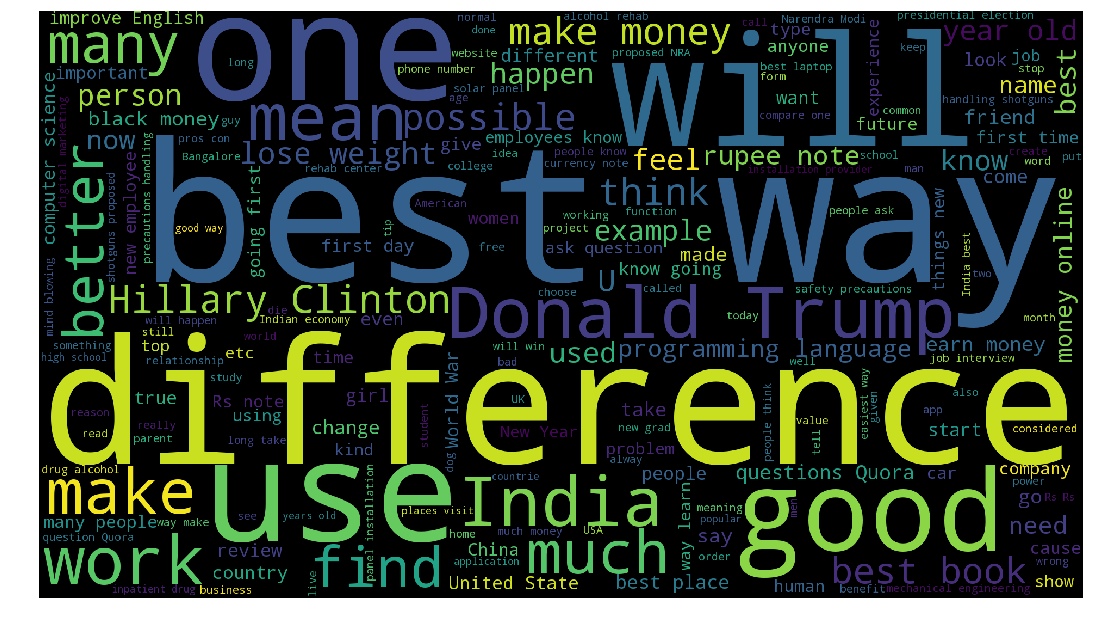

In [6]:
questions = pd.Series(train.question1.tolist() + train.question2.tolist()).astype(str)

cloud = WordCloud(width=1920, height=1080).generate(" ".join(questions))
plt.figure(figsize=(19.2, 10.8))
plt.imshow(cloud)
plt.axis('off')
plt.savefig('word_cloud.png')

## Feature engineering
Let's create a couple of features for our model. These are some pretty naive features and don't take a long time to be created. We will try to fit a model with all the features and see if feature pruning will incrase the models performance.

In [7]:
def word_share(row):
    q1_words = set(word_tokenize(row['question1']))
    q2_words = set(word_tokenize(row['question2']))
       
    return len(q1_words.intersection(q2_words)) / (len(q1_words.union(q2_words)))

def same_first_word(row):
    q1_words = word_tokenize(row['question1'])
    q2_words = word_tokenize(row['question2'])
    
    return float(q1_words[0].lower() == q2_words[0].lower())

EPSILON = 0.0000001

In [8]:
train['word_share'] = train.apply(word_share, axis=1)

train['q1_word_num'] = train.question1.apply(lambda x: len(word_tokenize(x)))
train['q2_word_num'] = train.question2.apply(lambda x: len(word_tokenize(x)))
train['word_num_difference'] = abs(train.q1_word_num - train.q2_word_num)

train['q1_length'] = train.question1.apply(lambda x: len(x))
train['q2_length'] = train.question2.apply(lambda x: len(x))
train['length_difference'] = abs(train.q1_length - train.q2_length)

train['q1_has_fullstop'] = train.question1.apply(lambda x: int('.' in x))
train['q2_has_fullstop'] = train.question2.apply(lambda x: int('.' in x))

train['q1_digit_count'] = train.question1.apply(lambda question: sum([word.isdigit() for word in question]))
train['q2_digit_count'] = train.question2.apply(lambda question: sum([word.isdigit() for word in question]))
train['digit_count_difference'] = abs(train.q1_digit_count - train.q2_digit_count)

train['q1_capital_char_count'] = train.question1.apply(lambda question: sum([word.isupper() for word in question]))
train['q2_capital_char_count'] = train.question2.apply(lambda question: sum([word.isupper() for word in question]))
train['capital_char_count_difference'] = abs(train.q1_capital_char_count - train.q2_capital_char_count)

train['q1_has_math_expression'] = train.question1.apply(lambda x: int('[math]' in x))
train['q2_has_math_expression'] = train.question2.apply(lambda x: int('[math]' in x))      

train['same_first_word'] = train.apply(same_first_word, axis=1)

train['log_word_share'] = np.log(train.word_share + EPSILON)
train['word_share_squared'] = train.word_share ** 2
train['word_share_sqrt'] = np.sqrt(train.word_share)

train['log_length_difference'] = np.log(train.length_difference + EPSILON)
train['length_difference_squared'] = train.length_difference ** 2
train['length_difference_sqrt'] = np.sqrt(train.length_difference)

In [9]:
features = ['word_share', 'q1_word_num', 'q2_word_num', 'word_num_difference', 'q1_length', 'q2_length',
            'length_difference', 'q1_has_fullstop', 'q2_has_fullstop', 'q1_digit_count', 'q2_digit_count',
            'digit_count_difference', 'q1_capital_char_count', 'q2_capital_char_count',
            'capital_char_count_difference', 'q1_has_math_expression', 'q2_has_math_expression',
           'log_word_share', 'word_share_squared', 'word_share_sqrt', 'log_length_difference',
           'length_difference_squared', 'length_difference_sqrt', 'same_first_word']

target = 'is_duplicate'

In [10]:
X = train[features]
y = train[target]

## Cross validation
Here we split the dataset with the 20% of data going to the validation set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model performance
To evaluate the model we will use the log_loss function that is used in the competition. The score that we get is not that great, let's see if we can improve it.

In [12]:
model = RandomForestClassifier(50, n_jobs=8)
model.fit(X_train, y_train)

predictions_proba = model.predict_proba(X_test)
predictions = model.predict(X_test)

log_loss_score = log_loss(y_test, predictions_proba)
acc = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print('Log loss: %.5f' % log_loss_score)
print('Acc: %.5f' % acc)
print('F1: %.5f' % f1)

Log loss: 0.63232
Acc: 0.71078
F1: 0.59364


## Feature importance
Here we can see the factor of performance of each feature in the xgboost model.

In [13]:
model = XGBClassifier(n_estimators=500)
model.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

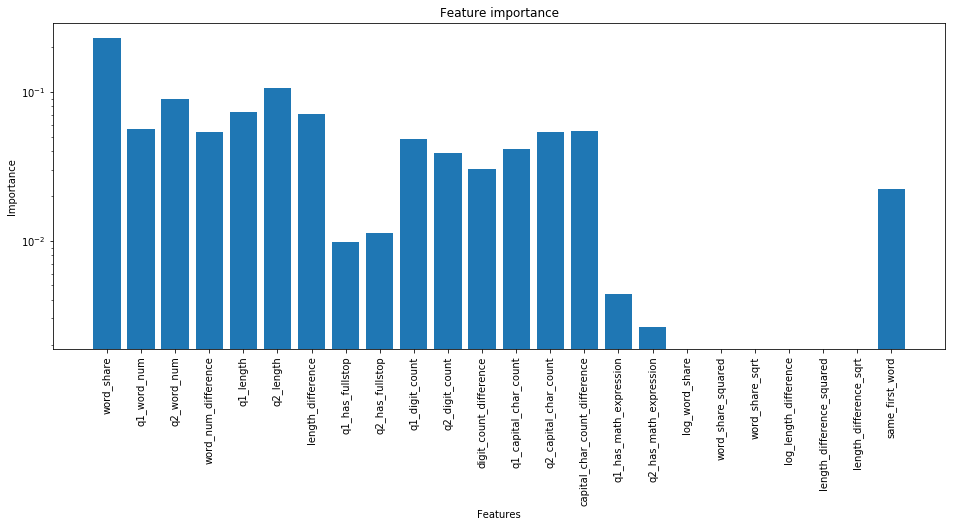

In [14]:
feature_importance = model.feature_importances_

plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')

plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), features, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()
plt.savefig('feature_importance.png')

In [15]:
feature_importances = pd.DataFrame(model.feature_importances_, columns=['weights'], index=features)
feature_importances

,weights
word_share,0.231417
q1_word_num,0.056330
q2_word_num,0.089721
word_num_difference,0.053717
q1_length,0.073751
q2_length,0.106852
length_difference,0.070557
q1_has_fullstop,0.009872
q2_has_fullstop,0.011324
q1_digit_count,0.048200


In [16]:
def extract_pruned_features(feature_importances, min_score=0.05):
    column_slice = feature_importances[feature_importances['weights'] > min_score]
    return column_slice.index.values

## Model performance with feature pruning

In [17]:
pruned_featurse = extract_pruned_features(feature_importances, min_score=0.01)
print('Pruned features:', pruned_featurse)

Pruned features: ['word_share' 'q1_word_num' 'q2_word_num' 'word_num_difference' 'q1_length'
 'q2_length' 'length_difference' 'q2_has_fullstop' 'q1_digit_count'
 'q2_digit_count' 'digit_count_difference' 'q1_capital_char_count'
 'q2_capital_char_count' 'capital_char_count_difference' 'same_first_word']


In [18]:
X_train_reduced = X_train[pruned_featurse]
X_test_reduced = X_test[pruned_featurse]

In [19]:
def fit_and_print_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)

    predictions_proba = model.predict_proba(X_test)
    predictions = model.predict(X_test)

    log_loss_score = log_loss(y_test, predictions_proba)
    acc = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    print('Log loss: %.5f' % log_loss_score)
    print('Acc: %.5f' % acc)
    print('F1: %.5f' % f1)

### Pruned features

In [20]:
model = RandomForestClassifier(50, n_jobs=8)
fit_and_print_metrics(X_train_reduced, y_train, X_test_reduced, y_test, model)

Log loss: 0.59251
Acc: 0.71997
F1: 0.60576


### All features

In [21]:
model = RandomForestClassifier(50, n_jobs=8)
fit_and_print_metrics(X_train, y_train, X_test, y_test, model)

Log loss: 0.63376
Acc: 0.70999
F1: 0.59261


## Feature pruning performance visualization

In [22]:
weights = sorted(feature_importances.weights.values)
model = RandomForestClassifier(50, n_jobs=8)
log_losses = []

best_loss = 10
best_weight = 0

for weight in weights:
    pruned_featurse = extract_pruned_features(feature_importances, min_score=weight - EPSILON)
    
    X_train_reduced = X_train[pruned_featurse]
    X_test_reduced = X_test[pruned_featurse]
    
    model.fit(X_train_reduced, y_train)
    loss = log_loss(y_test, model.predict_proba(X_test_reduced))
    log_losses.append(loss)
    
    if loss < best_loss:
        best_loss = loss
        best_weight = weight

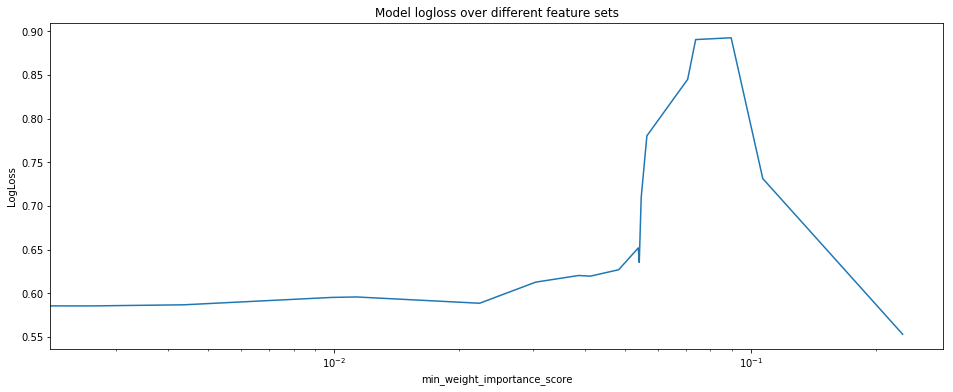

In [23]:
plt.figure(figsize=(16, 6))
plt.xscale('log', nonposy='clip')

plt.plot(weights, log_losses)

plt.title('Model logloss over different feature sets')
plt.ylabel('LogLoss')
plt.xlabel('min_weight_importance_score')

plt.show()

## Optimal pruning

In [24]:
print('Optimal loss: %.4f' % best_loss)
print('Optimal weigh for pruning: %.4f' % best_weight)

Optimal loss: 0.5531
Optimal weigh for pruning: 0.2314


In [25]:
pruned_featurse = extract_pruned_features(feature_importances, min_score=0.2314 - EPSILON)
print('Pruned features:', pruned_featurse)

X_train_reduced = X_train[pruned_featurse]
X_test_reduced = X_test[pruned_featurse]

model = RandomForestClassifier(50, n_jobs=8)
fit_and_print_metrics(X_train_reduced, y_train, X_test_reduced, y_test, model)

Pruned features: ['word_share']
Log loss: 0.55305
Acc: 0.67709
F1: 0.59020
